In [195]:
import sys
import os
import time
import random
import json
from datetime import timezone, datetime
import string
import uuid
from uuid import UUID
import pandas as pd
import seaborn as sns
b_size=1500

In [196]:
def random_generator(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for x in range(size))

def random_hexgenerator():
    hexN="0x"+uuid.uuid4().hex
    return hexN[:18]
def timestamp_gen():
    ts=int(datetime.now(tz=timezone.utc).timestamp() * 1000)
    return ts

def gendata():
    u=str(uuid.uuid1())
    value = random.randint(1,90000)
    syscall_nr=random_generator(4,'12345')
    syscall_name=random_generator(6,"abcdefghijklmnopqrstuvwxyz")
    dtb=random_hexgenerator()
    rsp=random_hexgenerator()
    rip=random_hexgenerator()
    pid=random.randint(1,10000)
    vmid="vm"+random_generator(2,'1234')
    logtype=random_generator(3,'xyz')
    ACTIONS = []
    j=0
    
    action= {
        "_index": "elastic_perf",
        "_type": "logtype",
        "_source":{
                    'id': u,
                    'value': value,
                    'syscall_nr': syscall_nr,
                    'syscall_name': syscall_name,
                    'dtb': dtb,
                    'rsp':rsp,
                    'rip':rip,
                    'pid':pid,
                    'vmid':vmid,
                    'logtype':logtype
                }
    }
    while j<b_size:
        ACTIONS.append(action)
        j=j+1
        
    return ACTIONS

In [197]:
import elasticsearch
from elasticsearch.helpers import bulk
es = elasticsearch.Elasticsearch()

write_readings={}
 
documents_number = 20000 * 200000
j=0
itr=0
MAX_ITR=10
total_docs=0
#f = open('/home/apurv/Readings.csv', 'w')

In [198]:
startf = datetime.now();

batch=0
index_name="elastic_perf"

#bulk(es,gendata(),stats_only=True)

while itr<MAX_ITR:
    batchl=0
    start = datetime.now();
    while True:
        batchl=batchl+b_size
        bulk(es,gendata(),stats_only=False)
        timec=int((datetime.now() - start).total_seconds())
        if timec==1:
            j=j+1
            write_readings[j]=batchl
            itr=itr+1
            total_docs=total_docs + batchl
            break
                
print ('inserted ',total_docs, ' in ', (datetime.now() - startf).total_seconds(), 's')
print ('average inserts per second is :',total_docs/MAX_ITR)

inserted  118500  in  10.650512 s
average inserts per second is : 11850.0


In [199]:
res = es.search(index="elastic_perf",body={"from":0,"size":1000,"query": {"match_all": {}}})
print("%d documents found" % res['hits']['total'])

#for doc in res['hits']['hits']:
        #print(" Doc ID: %s\n" % (doc))

2237962 documents found


In [200]:
'''query={"query": {"match_all": {}}}
scanResp= es.search(index="elastic_perf", doc_type="logtype", body=query, search_type="scan", scroll="1m")  

response_tmp = es.scroll(scroll_id=scrollId, scroll= "1m")
scrollId = response_tmp['_scroll_id']
print (response_tmp)'''

'query={"query": {"match_all": {}}}\nscanResp= es.search(index="elastic_perf", doc_type="logtype", body=query, search_type="scan", scroll="1m")  \n\nresponse_tmp = es.scroll(scroll_id=scrollId, scroll= "1m")\nscrollId = response_tmp[\'_scroll_id\']\nprint (response_tmp)'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd10a2bc50>],
      dtype=object)

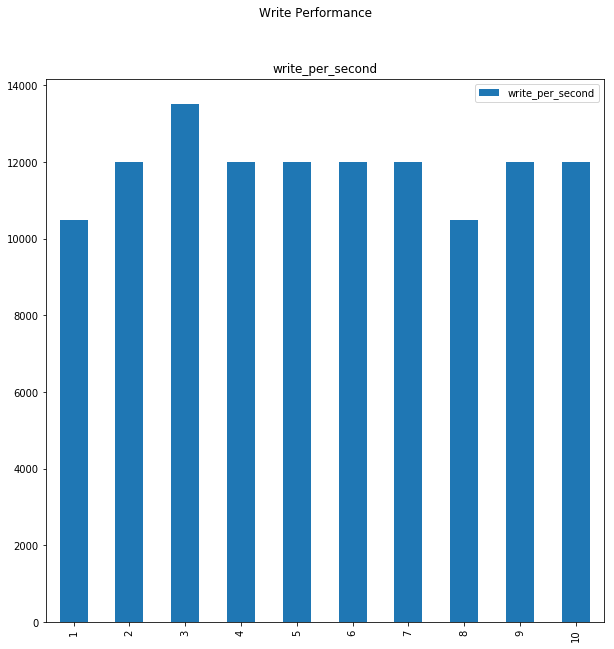

In [201]:
producer_df = pd.DataFrame.from_dict(write_readings, orient='index').rename(columns={0: 'write_per_second'})
producer_df.sort_index(inplace=True)
producer_df
producer_df.plot(kind='bar', subplots=True, figsize=(10, 10), title="Write Performance")